In [1]:
hmargs = {
    'aprx': 'paca',
    'basis': 'linear',
    'admis': '2',
    'eta': 0.8,
#     'eps': 0,
    'm': 4,
    'clf': 16,
    'eps_aca': 1e-2,     
    'rk': 0,
    'q_reg': 2,
    'q_sing': 4,
    'strict': True,
}
refn = 9
freqs = 0, 10e6, 1e6
c = 1500
rho = 1000

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from cnld import abstract, fem, bem, mesh
from cnld.arrays import matrix_array
from cnld.compressed_formats import MbkSparseMatrix

array = matrix_array(nelem=[1,2], shape='circle')
fs = np.arange(freqs[0], freqs[1] + freqs[2], freqs[2])

amesh = mesh.Mesh.from_abstract(array, refn)
ob = amesh.on_boundary
F = np.array(fem.array_f_spmatrix(array, refn).todense())
b = np.sum(F, axis=1)

nrmse = np.zeros(len(fs))
xfm_mean = np.zeros(len(fs))
xhm_mean = np.zeros(len(fs))

for i, f in enumerate(tqdm(fs)):
    
    omg = 2 * np.pi * f
    k = omg / c
    
    Gfe = fem.array_mbk_spmatrix(array, refn, f)
    Zfm = bem.array_z_matrix(array, refn, k, format='FullFormat', **hmargs)
    Zhm = bem.array_z_matrix(array, refn, k, format='HFormat', **hmargs)
    
    Gfm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zfm
    Ghm = MbkSparseMatrix(Gfe) + -omg**2 * 2 * rho * Zhm
    
    xfm = np.conj(Gfm.lu().lusolve(b))
    xfm[ob] = 0
    xhm = np.conj(Ghm.lu().lusolve(b))
    xhm[ob] = 0
    
    xfm_mean[i] = np.mean(np.abs(xfm))
    xhm_mean[i] = np.mean(np.abs(xhm))
    nrmse[i] = np.sqrt(np.sum(np.abs(xfm - xhm)**2)) / np.max(np.abs(xfm))

    
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, xfm_mean)
ax.plot(fs / 1e6, xhm_mean)

100%|██████████| 11/11 [01:25<00:00,  7.75s/it]


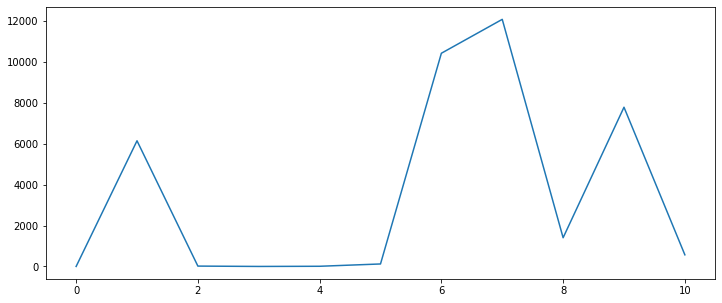

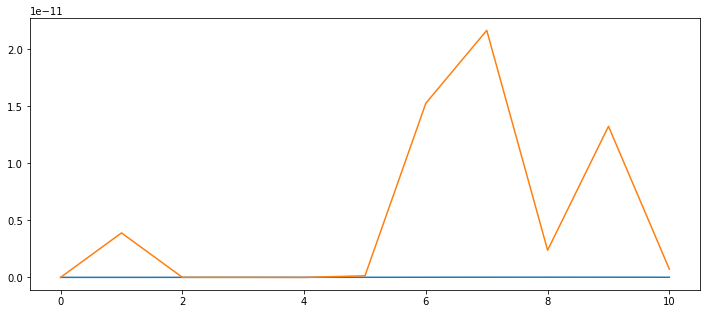

In [3]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, nrmse)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(fs / 1e6, xfm_mean)
ax.plot(fs / 1e6, xhm_mean)